# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need?
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

#### Import libraries

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

#### Load the data

In [2]:
### Specify the folder path for MC samples
path_data = 'data/'

### Open the file introducing file path
mc_data_ee = uproot.open(path_data+'ee.root')
mc_data_mm = uproot.open(path_data+'mm.root')
mc_data_qq = uproot.open(path_data+'qq.root')
mc_data_tt = uproot.open(path_data+'tt.root')
ttree_name = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
print(mc_data_ee[ttree_name].keys())

### Load branches
branches_ee = mc_data_ee[ttree_name].arrays()
branches_mm = mc_data_mm[ttree_name].arrays()
branches_qq = mc_data_qq[ttree_name].arrays()
branches_tt = mc_data_tt[ttree_name].arrays()

### List of variables (of interest)
vars=['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal']

### Read in the variables for all MC data samples
Pchar=ak.Array([branches_ee[vars[0]],branches_mm[vars[0]],branches_qq[vars[0]],branches_tt[vars[0]]])
Nchar=ak.Array([branches_ee[vars[1]],branches_mm[vars[1]],branches_qq[vars[1]],branches_tt[vars[1]]])
E_ecal=ak.Array([branches_ee[vars[2]],branches_mm[vars[2]],branches_qq[vars[2]],branches_tt[vars[2]]])
E_hcal=ak.Array([branches_ee[vars[3]],branches_mm[vars[3]],branches_qq[vars[3]],branches_tt[vars[3]]])

['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']


#### Plot the MC data samples to nice looking histograms

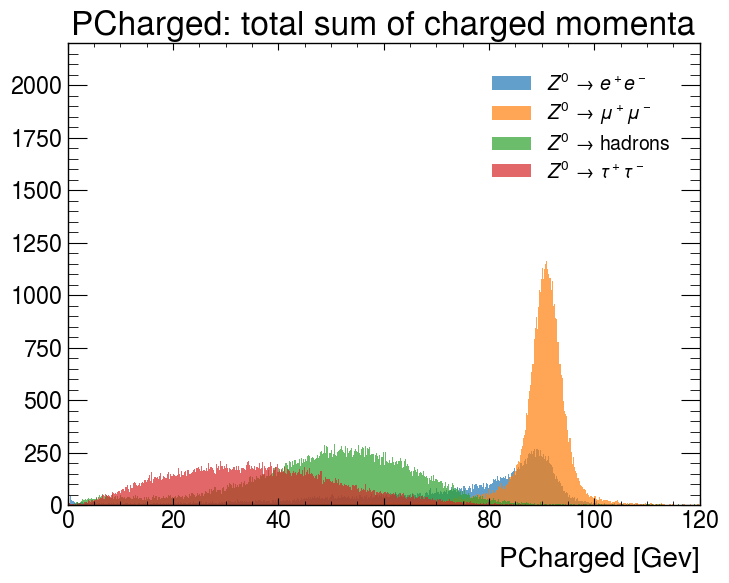

In [3]:
labels=[r'$Z^0$ $\to$ $e^+e^-$',r'$Z^0$ $\to$ $\mu^+\mu^-$',r'$Z^0$ $\to$ hadrons',r'$Z^0$ $\to$ $\tau^+\tau^-$']
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
plt.title(r'PCharged: total sum of charged momenta')
for i in np.arange(4):
    plt.hist(ak.to_numpy(Pchar[i]),bins=np.arange(0,120,0.1),label=labels[i],alpha=0.7)
    
plt.xlim(0,120)
plt.ylim(0,2200)
plt.xlabel(r'PCharged [Gev]')
plt.legend()
plt.show()

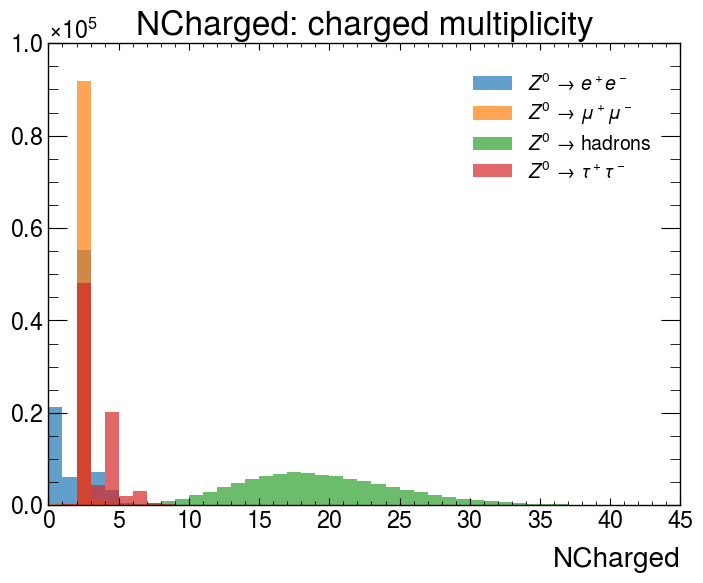

In [4]:
plt.title(r'NCharged: charged multiplicity')
for i in np.arange(4):
    plt.hist(ak.to_numpy(Nchar[i]),bins=np.arange(0,60,1),label=labels[i],alpha=0.7)

plt.xlim(0,45)
plt.ylim(0,100000)
plt.xlabel(r'NCharged')
plt.legend()
plt.show()

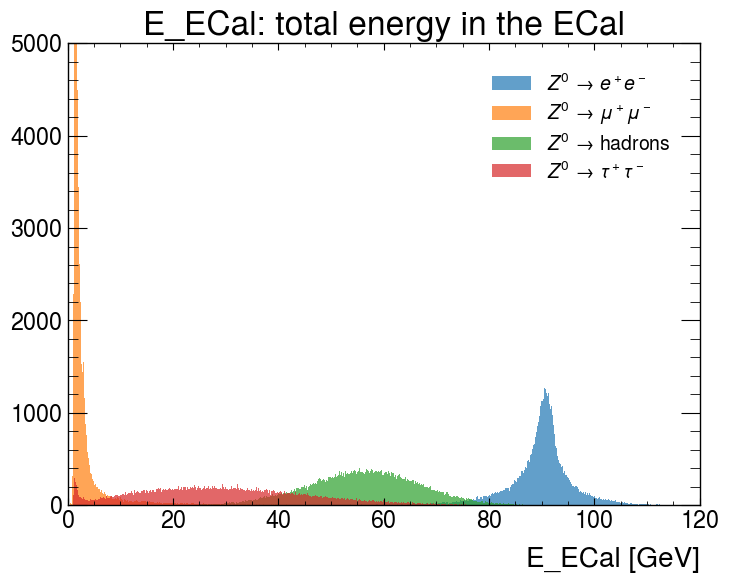

In [5]:
plt.title(r'E_ECal: total energy in the ECal')
for i in np.arange(4):
    plt.hist(ak.to_numpy(E_ecal[i]),bins=np.arange(0,120,0.1),label=labels[i],alpha=0.7)

plt.xlim(0,120)
plt.ylim(0,5000)
plt.xlabel(r'E_ECal [GeV]')
plt.legend()
plt.show()

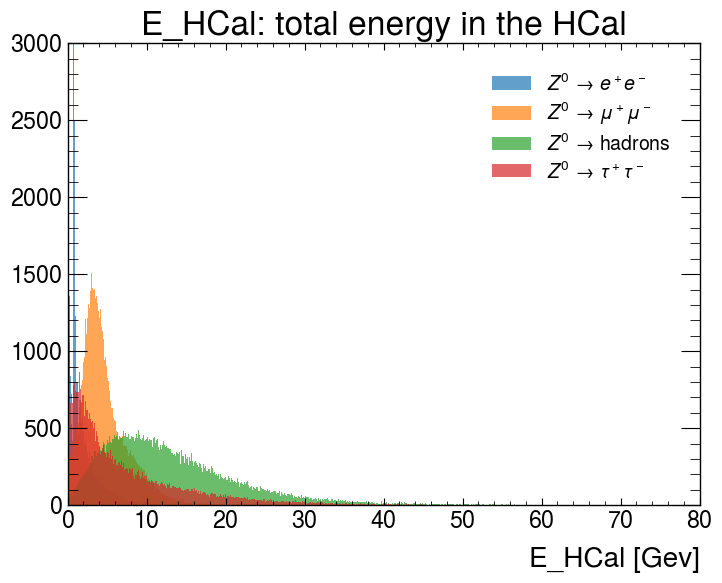

In [6]:
plt.title(r'E_HCal: total energy in the HCal')
for i in np.array([0,1,2,3]):
    plt.hist(ak.to_numpy(E_hcal[i]),bins=np.arange(0,80,0.08),label=labels[i],alpha=0.7)

plt.xlim(0,80)
plt.ylim(0,3000)
plt.xlabel(r'E_HCal [Gev]')
plt.legend()
plt.show()

#### Cut strategy
1. $Ncharged\begin{cases} > 7 \Rightarrow Z^0 \to \text{hadrons}, \text{break}.\\
       < 7  \Rightarrow Z^0 \to \begin{cases}e^+e^- \\ \mu^+\mu- \\ \tau^+\tau^- \end{cases}, \text{go to 2.}\end{cases}$ 
2. $E\text{_}ecal \begin{cases}> 70 \Rightarrow Z^0 \to e^+e^-, \text{break}.\\
 <70 \Rightarrow Z^0 \to \begin{cases}\mu^+\mu-  \\ \tau^+\tau^- \end{cases},\text{go to 3.}\end{cases}$
3. $Pcharged \begin{cases} > 75  \Rightarrow Z^0 \to \mu^+\mu- \text{break}. \\
                            <75\Rightarrow Z^0 \to \tau^+\tau- \text{break}. \end{cases}$

In [19]:
mymask_qq_1 = branches_qq['Ncharged'] >= 7
mymask_ee_1 = branches_ee['Ncharged'] < 7
mymask_mm_1 = branches_mm['Ncharged'] < 7
mymask_tt_1 = branches_tt['Ncharged'] < 7

print(f"{sum(mymask_qq_1)/len(mymask_qq_1)} % of the qq events passed the cut 1")
print(f"{(sum(mymask_ee_1)+sum(mymask_mm_1)+sum(mymask_tt_1))/(len(mymask_ee_1)+len(mymask_mm_1)+len(mymask_tt_1))} % of the ee/mm/tt events passed the cut 1")

0.9947241865608798 % of the qq events passed the cut 1
0.9962565025037678 % of the ee/mm/tt events passed the cut 1


In [20]:
mymask_ee_2= branches_ee['E_ecal'] >= 70
mymask_mm_2= branches_mm['E_ecal'] < 70
mymask_qq_2= branches_qq['E_ecal'] < 70
mymask_tt_2= branches_tt['E_ecal'] < 70


print(f"{sum(mymask_ee_2)/len(mymask_ee_2)} % of the ee events passed the cut 2")
print(f"{(sum(mymask_mm_1)+sum(mymask_tt_1))/(len(mymask_mm_1)+len(mymask_tt_1))} % of the mm/tt events passed the cut 2")


0.9820899341165433 % of the ee events passed the cut 2
0.9943777182522539 % of the mm/tt events passed the cut 2


In [21]:
mymask_ee_3= branches_ee['Pcharged'] < 70
mymask_mm_3= branches_mm['Pcharged'] >= 75
mymask_qq_3= branches_qq['Pcharged'] < 70
mymask_tt_3= branches_tt['Pcharged'] < 75


print(f"{sum(mymask_mm_3)/len(mymask_mm_3)} % of the mm events passed the cut 3")
print(f"{(sum(mymask_tt_1))/(len(mymask_tt_1))} % of the mm/tt events passed the cut 2")



0.9088693698943643 % of the mm events passed the cut 3
0.9876789456409221 % of the mm/tt events passed the cut 2
